In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
def show_corr(df):
    # make a clean matrix, the font can fit in the box
    plt.figure(figsize=(16, 16))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.show()

### Load data and Clean data

In [3]:
# Load data
datapath = 'Data/national_csv/national_tes.csv'
df = pd.read_csv(datapath)

# Drop unnecessary columns
drop_columns = [
    'tc_gap', 'treecanopy', # most values are -1
    'holc_grade', 'tesctyscor', # NULL values
    'GEOID', 'place', 'state', 'state_abbr','county', 'ua_name', 'congressio','cnpysource', # unnecessary
    'cbg_pop', 'priority_i', 'pctpoc', 'pctpov', 'unemplrate', 'dep_ratio','dep_perc', 'linguistic', 'temp_diff' # high corr
]
df = df.drop(drop_columns, axis=1)

### Split data

In [4]:
X, y = df.drop('unemplnorm', axis=1), df['unemplnorm']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, 
                                                random_state=42,
                                                test_size = .2)

### Target Encoding for Categorical Features

In [5]:
from category_encoders import TargetEncoder

# Create the target encoder
encoder = TargetEncoder()

# Fit the encoder on the development set (you should pass both the feature and the target)
encoder.fit(X_dev['biome'].astype(str), y_dev)

# Transform the feature (apply the encoding)
transformed_biome = encoder.transform(X_dev['biome'].astype(str))
transformed_biome_test = encoder.transform(X_test['biome'].astype(str))

X_dev['biome_target'] = transformed_biome
X_test['biome_target'] = transformed_biome_test

### Reset Index

In [6]:
X_dev.reset_index(drop=True, inplace=True)  
X_test.reset_index(drop=True, inplace=True)

### Save the dataframe to local

In [7]:
# if there is no finalized data folder, create one
import os
if not os.path.exists('finalized_data'):
    os.makedirs('finalized_data')

# save the data
X_dev.to_csv('finalized_data/X_dev.csv', index=False)
X_test.to_csv('finalized_data/X_test.csv', index=False)
y_dev.to_csv('finalized_data/y_dev.csv', index=False)
y_test.to_csv('finalized_data/y_test.csv', index=False)


### Helper function for reading data

In [8]:
# read_data helper function
def read_data():
    X_dev = pd.read_csv('finalized_data/X_dev.csv')
    X_test = pd.read_csv('finalized_data/X_test.csv')
    y_dev = pd.read_csv('finalized_data/y_dev.csv')
    y_test = pd.read_csv('finalized_data/y_test.csv')
    return X_dev, X_test, y_dev, y_test

In [ ]:
del X_dev['biome']

In [22]:
del X_test['biome']

### Model

In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

del X_dev['biome']

xgb = RandomizedSearchCV(XGBRegressor(random_state = 40),
 param_distributions = {'gamma': [0,.01,.03,.05,.08,.1],
 'eta' : [.1,.05,.01,.005,.001],
 'max_depth' : [3,4,5,6,7]},
 cv = 10)

xgb.fit(X_dev, y_dev)
print('xgboost Best score:', xgb.best_score_)
print('xgboost Best alpha:', xgb.best_params_)

xgboost Best score: 0.2318184729672219
xgboost Best alpha: {'max_depth': 6, 'gamma': 0.05, 'eta': 0.1}


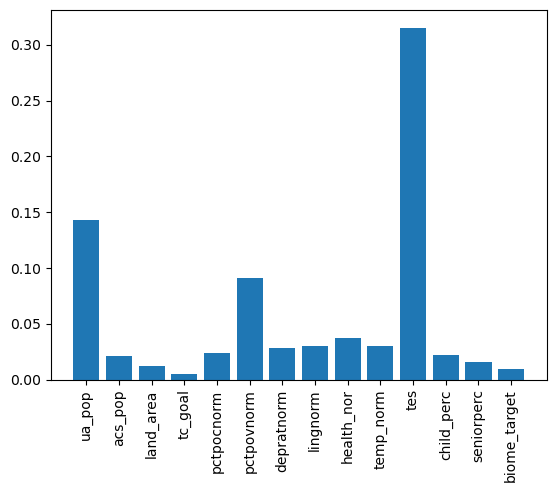

In [11]:
from sklearn.inspection import permutation_importance

perm_rand = permutation_importance(xgb, X_dev, y_dev)
mean_perm_rand = perm_rand.importances_mean
plt.bar(X_dev.columns, mean_perm_rand)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# removing all put top 4
top_feats = ['ua_pop', 'pctpovnorm', 'tes', 'health_nor']
X_dev_top_feats = X_dev[top_feats]
X_test_top_feats = X_test[top_feats]

In [23]:
xgb2 = XGBRegressor(random_state = 40, 
                    max_depth= 6, gamma= 0.05, eta= 0.1)

xgb2.fit(X_dev, y_dev)
print('xgboost train score:', xgb2.score(X_dev, y_dev))
print('xgboost test score:', xgb2.score(X_test, y_test))

xgboost train score: 0.3026503980545232
xgboost test score: 0.2280511229049843
